In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import torch.nn as nn
import torch
import itertools

from emnist import get_emnist_data_loaders
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
from training.trainer import Trainer
from hyperparameter import common_hyperparameters, model_specific_hyperparameters
from evaluation.loss import plot_loss, plot_multiple_losses
from evaluation.evaluations_utils import create_directory_if_not_exists
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, LambdaLR, CyclicLR

In [15]:
# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(*model_specific_hyperparameters.values()))
print(f"Number of Hyperparameter combinations: {len(param_combinations)}")

# TODO Remove in final notebook
param_combinations = param_combinations[:3]

Number of Hyperparameter combinations: 12


In [16]:
trainers = {}
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    num_classes = common_hyperparameters["NUM_CLASSES"]   
    blank_label = common_hyperparameters["BLANK_LABEL"]
    image_height = common_hyperparameters["IMAGE_HEIGHT"]
    digits_per_sequence = common_hyperparameters["DIGITS_PER_SEQUENCE"]
    number_of_sequences = common_hyperparameters["NUMBER_OF_SEQUENCES"]
    epochs = common_hyperparameters["EPOCHS"]
    weight_decay = common_hyperparameters["WEIGHT_DECAY"]

    # Load data
    train_loader, val_loader, test_loader = get_emnist_data_loaders(number_of_sequences, digits_per_sequence, batch_size, batch_size_val)


    # Setup model
    models = {
        # "lstm_cnn": CNN_LSTM(gru_hidden_size=gru_hidden_size, gru_num_layers=gru_num_layers, num_classes=num_classes, cnn_output_height=cnn_output_height),
        "crnn": CRNN(gru_hidden_size, gru_num_layers, num_classes, cnn_output_height)
    }

    criteria = {
        "crnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True),
        "lstm_cnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True)
    }

    optimizer_configs = {
        "adam": torch.optim.Adam,
        # "adam_w": torch.optim.AdamW,
        # "adam_w_regulise": torch.optim.AdamW
    }

    scheduler_configs = {
        "step_lr": (StepLR, {"step_size": 5, "gamma": 0.5}),
        "no_scheduler": (None, None),
        # "multi_step_lr": (MultiStepLR, {"milestones": [5, 10, 15], "gamma": 0.5}),
        # "exponential_lr": (ExponentialLR, {"gamma": 0.95}),
        # "cosine_annealing_lr": (CosineAnnealingLR, {"T_max": 10}),
        # "lambda_lr": (LambdaLR, {"lr_lambda": lambda epoch: 0.95 ** epoch}),
        # "cyclic_lr": (CyclicLR, {"base_lr": 0.001, "max_lr": 0.1})
    }

    # Setup trainer
    # lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, test_loader, epochs=epochs, args={
    #         "blank_label": blank_label,
    #         "cnn_output_width": cnn_output_width,
    #     })
    # trainers = {
    #     "lstm_cnn": lstm_trainer
    # }

    for model_name, model in models.items():
        for optimizer_name, optimizer_class in optimizer_configs.items():
            if optimizer_name == "adam_w_regulise":
                optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            for scheduler_name, (scheduler_class, scheduler_args) in scheduler_configs.items():
                if scheduler_name == "no_scheduler":
                    scheduler = None
                else:
                    scheduler = scheduler_class(optimizer, **scheduler_args)
                criterion = criteria[model_name]

                # Create model name
                abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
                abbreviation = abbreviation.replace(".", "_")
                main_model_name = model_name.split('-', 1)[0]
                trainer_name = f"{model_name}-{optimizer_name}_{scheduler_name}_{abbreviation}"

                trainer = Trainer(
                    model, model_name, criterion, optimizer, train_loader, val_loader, test_loader,
                    epochs=epochs, args={"blank_label": blank_label, "cnn_output_width": cnn_output_width},
                    scheduler=scheduler
                )
                # trainer.to_device("mps")
                trainers[trainer_name] = trainer
print(f"Prepared {len(trainers)} models for training.")

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 64, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 128, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.001, 
Batch Size: 64, 
Validation Batch Size: 64 

Prepared 6 models for training.


Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 11/11 [00:02<00:00,  3.69it/s]
EPOCH 1/16 - TRAINING. Loss: 3.0744028091430664 - Correct: 0/700 = 0.0000 - Average CER Score: 0.917
100%|██████████| 5/5 [00:00<00:00,  9.91it/s]
EPOCH 1/16 - VALIDATING. Loss: 3.6503450870513916 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
EPOCH 2/16 - TRAINING. Loss: 2.7691245079040527 - Correct: 0/700 = 0.0000 - Average CER Score: 0.958
100%|██████████| 5/5 [00:00<00:00, 11.45it/s]
EPOCH 2/16 - VALIDATING. Loss: 2.7857768535614014 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
EPOCH 3/16 - TRAINING. Loss: 2.6527926921844482 - Correct: 0/700 = 0.0000 - Average CER Score: 0.972
100%|██████████| 5/5 [00:00<00:00, 11.23it/s]
EPOCH 3/16 - VALIDATING. Loss: 2.621450901031494 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.86it

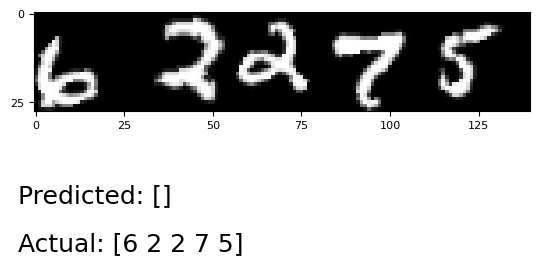

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 54.11202383041382 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 11/11 [00:02<00:00,  3.73it/s]
EPOCH 1/16 - TRAINING. Loss: 2.6288769245147705 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.80it/s]
EPOCH 1/16 - VALIDATING. Loss: 2.6129250526428223 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
EPOCH 2/16 - TRAINING. Loss: 2.620776653289795 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
EPOCH 2/16 - VALIDATING. Loss: 2.625272512435913 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
EPOCH 3/16 - TRAINING. Loss: 2.6080169677734375 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
EPOCH 3/16 - VALIDATING. Loss: 2.6155

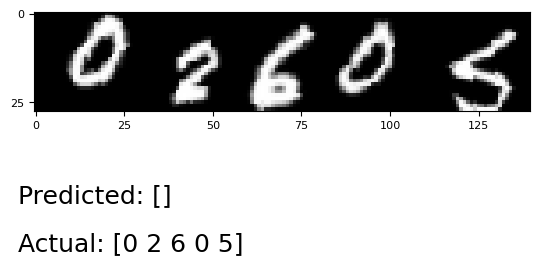

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 54.051385164260864 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 6/6 [00:02<00:00,  2.16it/s]
EPOCH 1/16 - TRAINING. Loss: 10.990238189697266 - Correct: 0/700 = 0.0000 - Average CER Score: 0.922
100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
EPOCH 1/16 - VALIDATING. Loss: 10.80733585357666 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.876
100%|██████████| 6/6 [00:03<00:00,  1.94it/s]
EPOCH 2/16 - TRAINING. Loss: 2.94246506690979 - Correct: 0/700 = 0.0000 - Average CER Score: 0.927
100%|██████████| 5/5 [00:00<00:00, 10.13it/s]
EPOCH 2/16 - VALIDATING. Loss: 2.8515067100524902 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.938
100%|██████████| 6/6 [00:03<00:00,  1.76it/s]
EPOCH 3/16 - TRAINING. Loss: 3.341942071914673 - Correct: 0/700 = 0.0000 - Average CER Score: 0.952
100%|██████████| 5/5 [00:00<00:00,  9.85it/s]
EPOCH 3/16 - VALIDATING. Loss: 3.

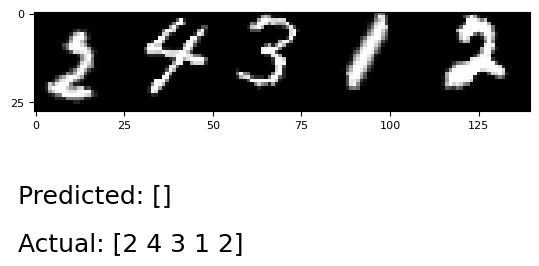

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 57.998332262039185 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
EPOCH 1/16 - TRAINING. Loss: 2.6410257816314697 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.22it/s]
EPOCH 1/16 - VALIDATING. Loss: 2.6336729526519775 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.85it/s]
EPOCH 2/16 - TRAINING. Loss: 2.6256215572357178 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00,  9.28it/s]
EPOCH 2/16 - VALIDATING. Loss: 2.637772798538208 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.92it/s]
EPOCH 3/16 - TRAINING. Loss: 2.628847360610962 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00,  9.75it/s]
EPOCH 3/16 - VALIDATING. Loss: 2.6305649

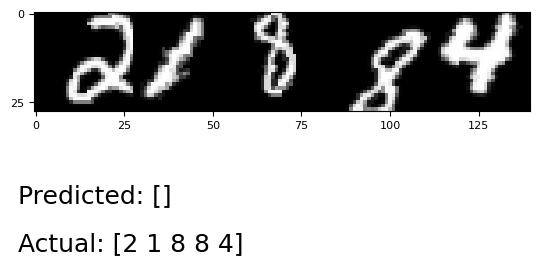

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 58.86663293838501 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.50it/s]
EPOCH 1/16 - TRAINING. Loss: 2.8101601600646973 - Correct: 0/700 = 0.0000 - Average CER Score: 0.994
100%|██████████| 5/5 [00:00<00:00,  9.18it/s]
EPOCH 1/16 - VALIDATING. Loss: 2.6286704540252686 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.51it/s]
EPOCH 2/16 - TRAINING. Loss: 2.727937936782837 - Correct: 0/700 = 0.0000 - Average CER Score: 0.997
100%|██████████| 5/5 [00:00<00:00, 10.33it/s]
EPOCH 2/16 - VALIDATING. Loss: 2.6987156867980957 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
EPOCH 3/16 - TRAINING. Loss: 2.619748592376709 - Correct: 0/700 = 0.0000 - Average CER Score: 0.998
100%|██████████| 5/5 [00:00<00:00,  9.65it/s]
EPOCH 3/16 - VALIDATING. Loss

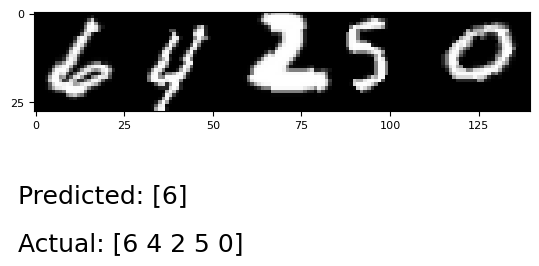

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 61.078370094299316 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.37it/s]
EPOCH 1/16 - TRAINING. Loss: 1.7049890756607056 - Correct: 0/700 = 0.0000 - Average CER Score: 0.905
100%|██████████| 5/5 [00:00<00:00,  9.45it/s]
EPOCH 1/16 - VALIDATING. Loss: 1.7256842851638794 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.862
100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
EPOCH 2/16 - TRAINING. Loss: 1.7080156803131104 - Correct: 0/700 = 0.0000 - Average CER Score: 0.894
100%|██████████| 5/5 [00:00<00:00,  9.28it/s]
EPOCH 2/16 - VALIDATING. Loss: 1.6910675764083862 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.849
100%|██████████| 11/11 [00:03<00:00,  3.50it/s]
EPOCH 3/16 - TRAINING. Loss: 1.6165318489074707 - Correct: 0/700 = 0.0000 - Average CER Score: 0.878
100%|██████████| 5/5 [00:00<00:00,  9.73it/s]
EPOCH 3/16 - VALIDATIN

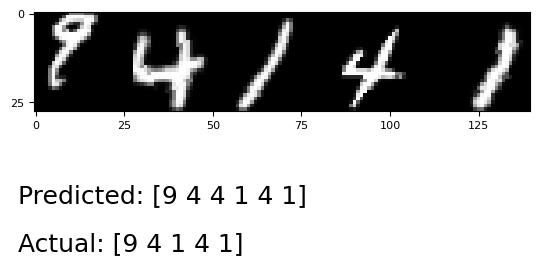

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 60.29616618156433 seconds.


In [18]:
import time

metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    start_time = time.time()
    metrics = trainer.train_validate_test()
    end_time = time.time()
    print(f"Finished training {model_name} and took {end_time - start_time} seconds.")
    
    # Save the trained model with abbreviation and parameter values
    main_model_name = model_name.split('-', 1)[0]
    base_path = f'models/{main_model_name}/{model_name}/'

    # Add metrics to model name
    metrics_global[f"{model_name}"] = metrics
    
    # Save model to disk
    create_directory_if_not_exists(base_path)
    save_path = base_path + "model.pth"
    torch.save(trainer.model.state_dict(), save_path)

In [19]:
from utils import get_dict_from_pkl, save_dict_to_pkl

# Save and load metrics to file
save_dict_to_pkl(metrics_global, "metrics_global")
grid_search_metrics = get_dict_from_pkl("metrics_global")

In [20]:
# Get top 5 models based on loss
top_models = {}

for model_name, model_scores_top_5 in grid_search_metrics.items():
    model_loss = model_scores_top_5["test_loss"][0]
    top_models[model_name] = model_loss

# Sort models by loss (ascending order)
sorted_models = dict(sorted(top_models.items(), key=lambda item: item[1]))

# Get top 5 models
top_5_models = dict(list(sorted_models.items())[:5])

# Create a new dictionary with numerical keys
numerical_top_models = {model: {"id": idx, "loss": loss} for idx, (model, loss) in enumerate(top_5_models.items())}

# Print the top 5 models with numerical keys
for item in numerical_top_models.items():
    print(item)

('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 0, 'loss': 1.2989161014556885})
('crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 1, 'loss': 2.355731725692749})
('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64', {'id': 2, 'loss': 2.5588488578796387})
('crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64', {'id': 3, 'loss': 2.5749547481536865})
('crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64', {'id': 4, 'loss': 2.6246604919433594})


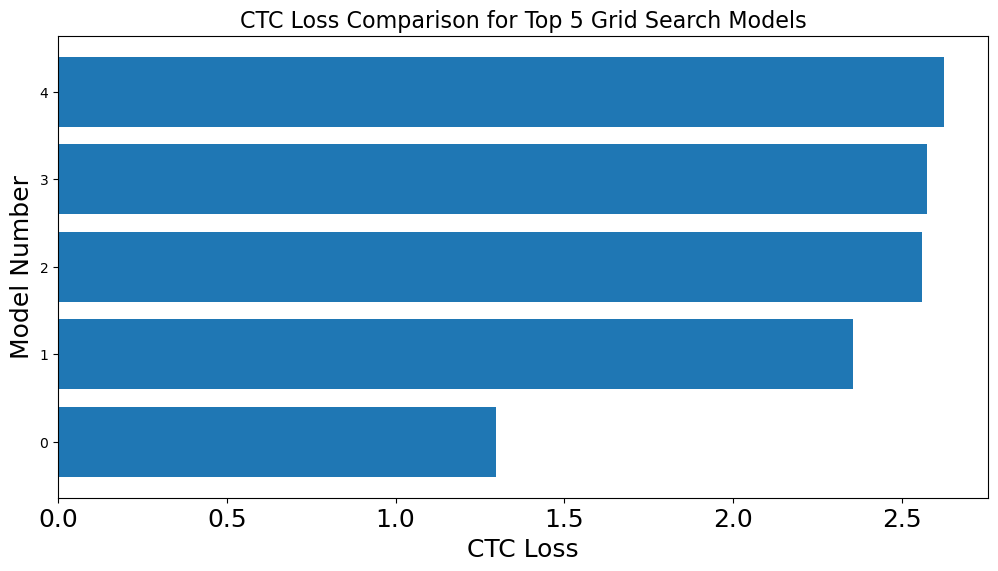

In [21]:
import numpy as np
from utils import split_and_insert_newline_list 
import matplotlib.pyplot as plt

model_names_top_5 = list(numerical_top_models.keys())
model_number_top_5 = [item["id"] for idx, item in numerical_top_models.items()]
model_scores_top_5 = [item["loss"] for idx, item in numerical_top_models.items()]

# Create a horizontal bar plot for all metrics
# Update fig size
plt.figure(figsize=(12, 6), dpi=100)

plt.barh(model_number_top_5, model_scores_top_5)  # Horizontal bar plot

plt.xlabel('CTC Loss')  # Adjust label
plt.ylabel('Model Number')  # Adjust label
plt.title('CTC Loss Comparison for Top 5 Grid Search Models', fontsize=16)  # Adjust title font size

# Customize font size for model names
plt.yticks(fontsize=10)

plt.show()


In [22]:
for model_name, trainer in trainers.items():
    main_model_name = model_name.split('-', 1)[0]
    # Get model paths
    base_path = f'models/{main_model_name}/{model_name}/'
    model_path = base_path + "model.pth"
    
    print(f"Saving Loss Plot for model: {model_name}")
    #model = model.to("mps")
    model.load_state_dict(torch.load(model_path))

    # Plot the trained model
    plot_loss(model_name=model_name, train_loss_per_epoch=trainer.metrics["train_loss"], val_loss_per_epoch=trainer.metrics["val_loss"], figure_evaluation_dir=base_path)

Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [23]:
#TODO Plot training and val for each model

model_ids = []
model_training_losses = []
model_val_losses = []

for model_name, trainer in trainers.items():
    if model_name in model_names_top_5:
        model_id = numerical_top_models[model_name]["id"]
        model_ids.append(model_id)
        model_training_losses.append(trainer.metrics["train_loss"])
        model_val_losses.append(trainer.metrics["val_loss"])

# Get model paths
main_model_name = model_name.split('-', 1)[0]
base_path = f'models/{main_model_name}/'

# Plot the trained model
plot_multiple_losses(
    model_names=model_ids, 
    train_losses_list=model_training_losses, 
    val_losses_list=model_val_losses, 
    figure_evaluation_dir=base_path
)

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 134.29it/s]
TESTING. Loss: 2.5588488578796387 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


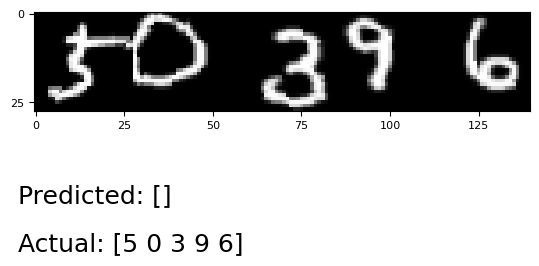

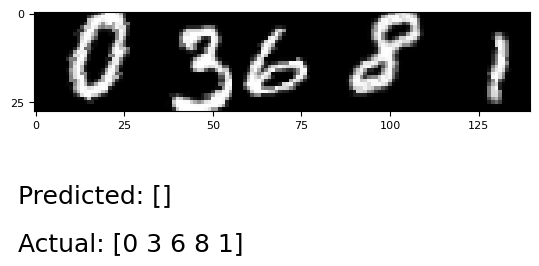

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 113.06it/s]
TESTING. Loss: 2.5588488578796387 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


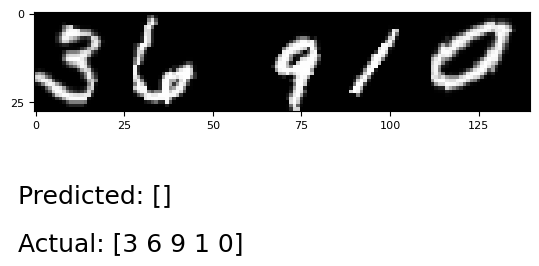

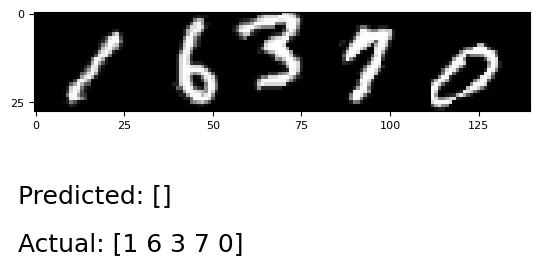

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 124.19it/s]
TESTING. Loss: 2.659001350402832 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.992


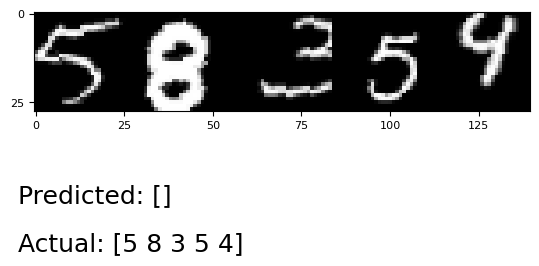

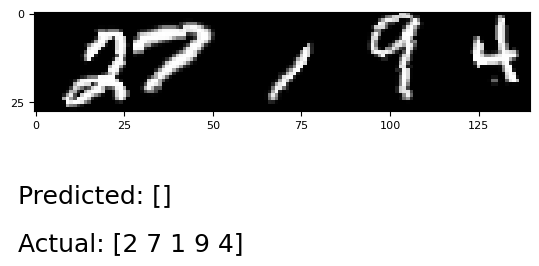

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 136.85it/s]
TESTING. Loss: 2.659001350402832 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


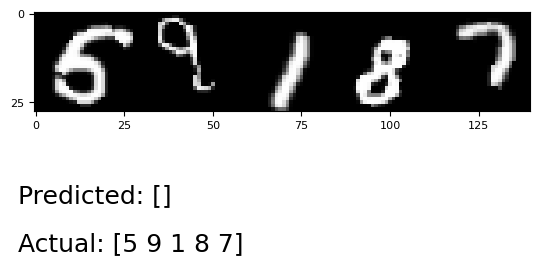

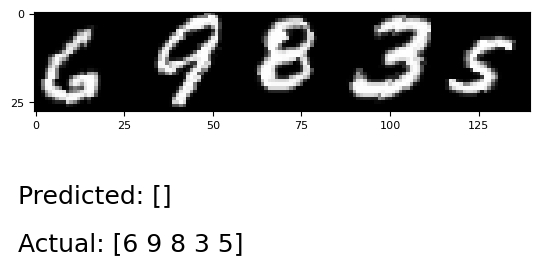

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 130.45it/s]
TESTING. Loss: 1.2989161014556885 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.984


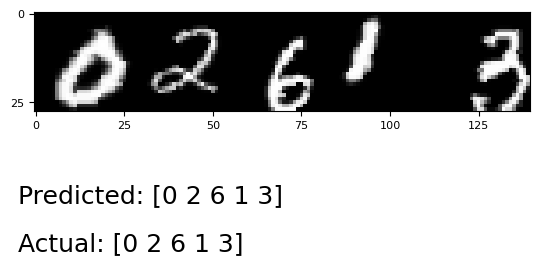

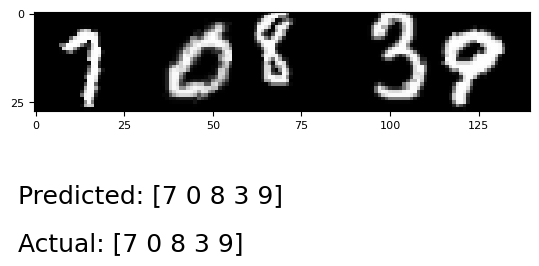

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 126.66it/s]
TESTING. Loss: 1.2989161014556885 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.554


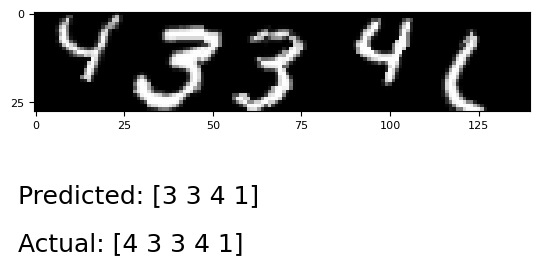

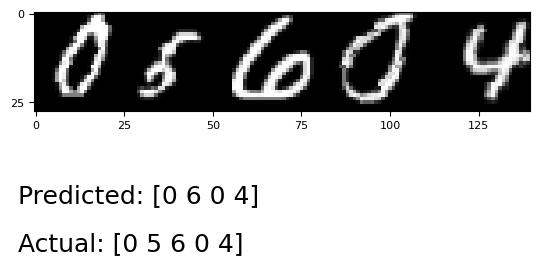

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 101.46it/s]
TESTING. Loss: 2.5588488578796387 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


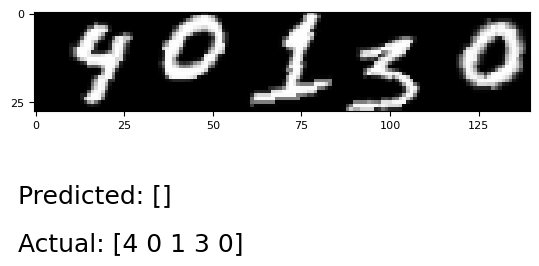

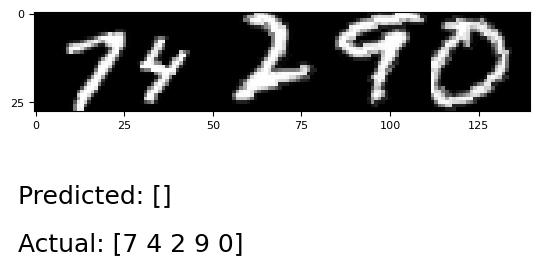

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 133.19it/s]
TESTING. Loss: 2.5588488578796387 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


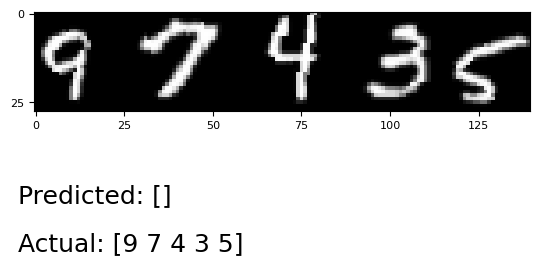

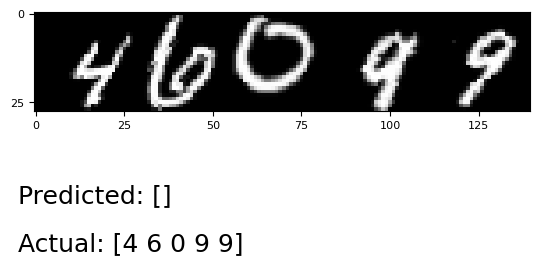

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 121.79it/s]
TESTING. Loss: 2.659001350402832 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.992


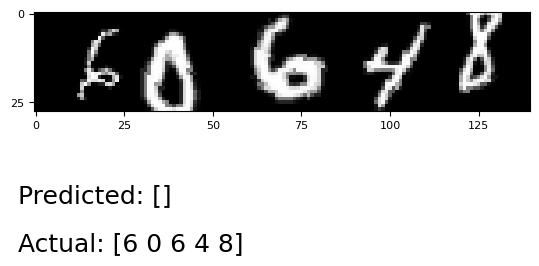

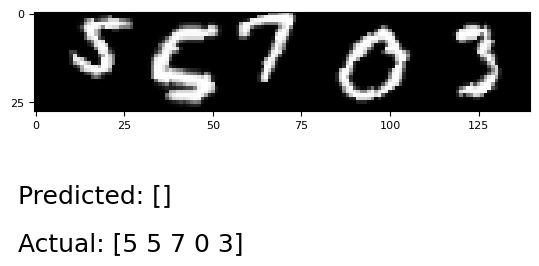

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 86.56it/s]
TESTING. Loss: 2.659001350402832 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


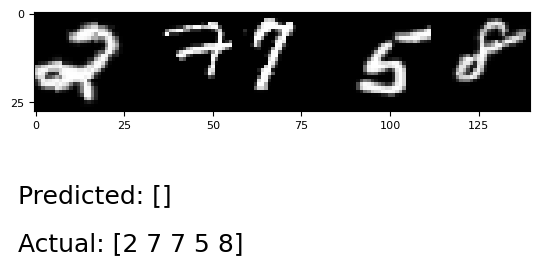

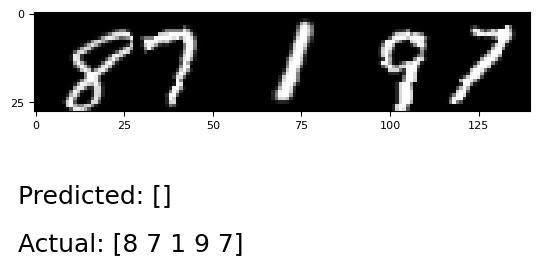

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 110.46it/s]
TESTING. Loss: 1.2989161014556885 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.984


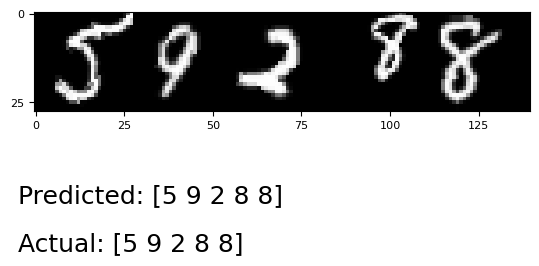

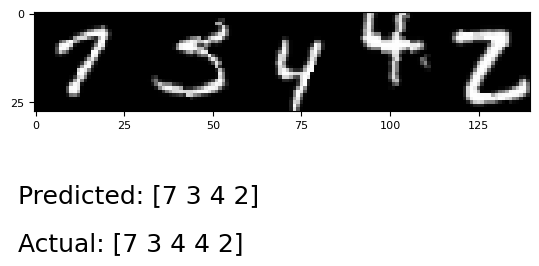

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 103.51it/s]
TESTING. Loss: 1.2989161014556885 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.554


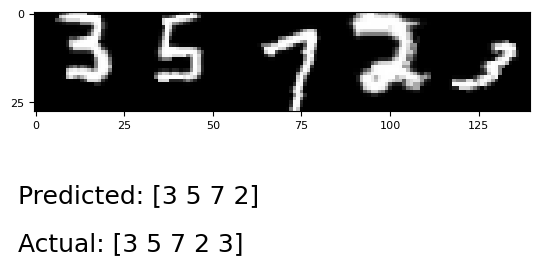

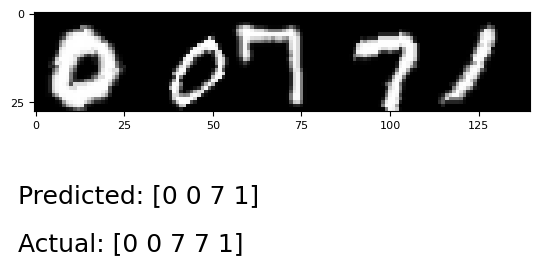

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 128.55it/s]
TESTING. Loss: 2.5588488578796387 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


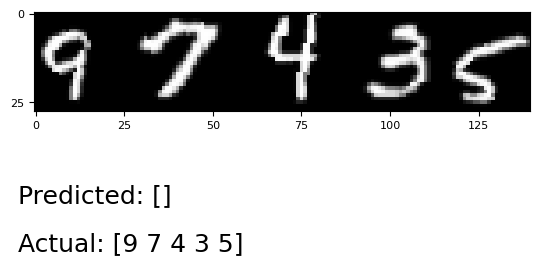

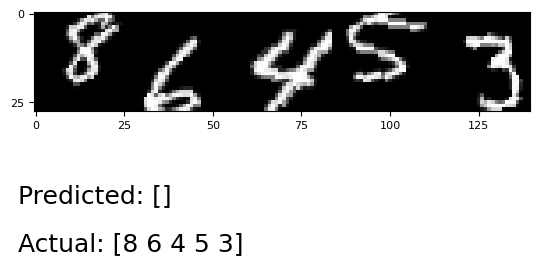

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 97.02it/s]
TESTING. Loss: 2.5588488578796387 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


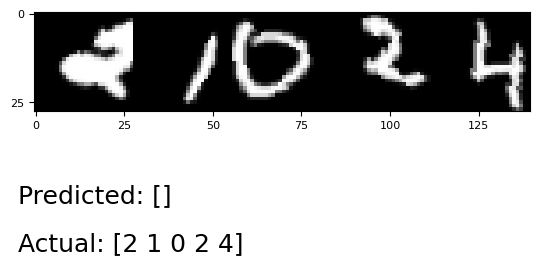

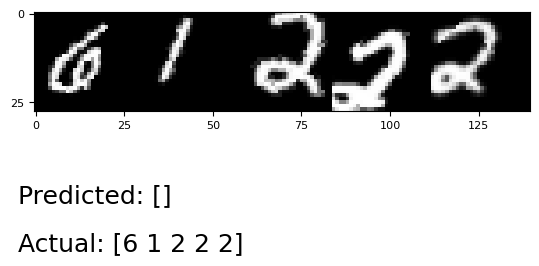

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 116.90it/s]
TESTING. Loss: 2.659001350402832 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.992


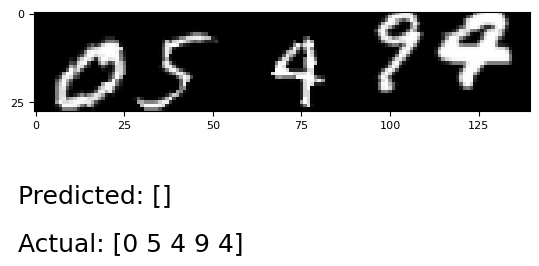

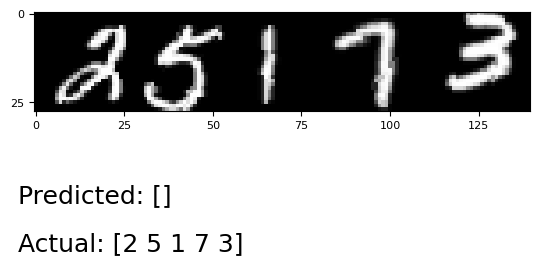

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 102.86it/s]
TESTING. Loss: 2.659001350402832 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


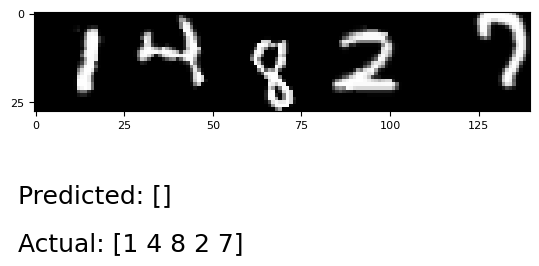

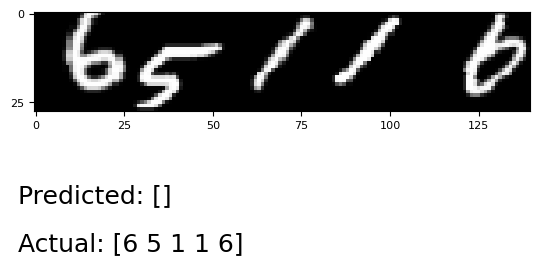

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 97.87it/s]
TESTING. Loss: 1.2989161014556885 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.984


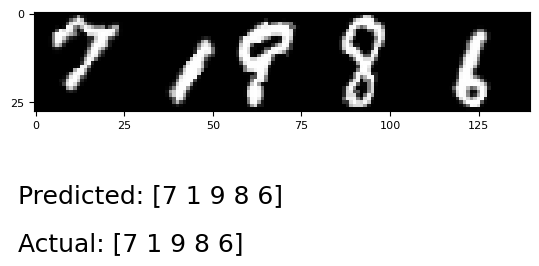

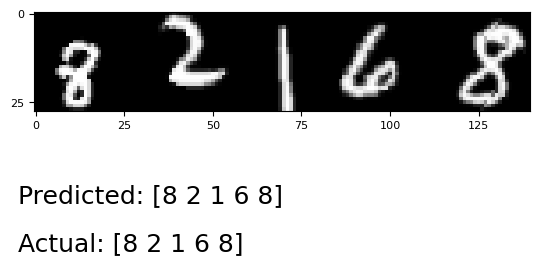

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 102.15it/s]
TESTING. Loss: 1.2989161014556885 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.554


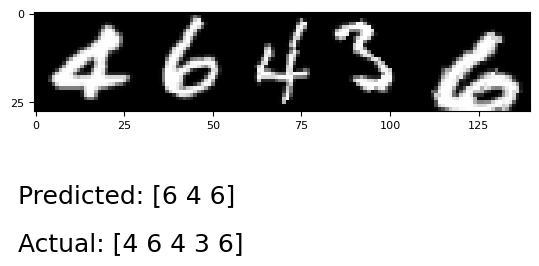

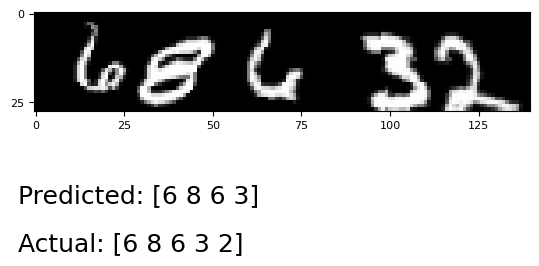

In [24]:
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    for model_name, trainer in trainers.items():
        print(f"Testing model {model_name}")

        # Plot the trained model
        trainer.test(plot_n=2)